# Telco Customer Churn

In [55]:
import os

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.manifold import TSNE, Isomap, LocallyLinearEmbedding
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px

## Exploratory Data Analysis

First, lets define the functions for plotting the data.

In [2]:
# Histogram of column data
def plot_histogram(df, n_histogram_shown, n_histogram_per_row):
    n_unique = df.nunique()
    df = df[[col for col in df if 1 < n_unique[col] < 50]]
    n_row, n_col = df.shape
    column_names = list(df)
    n_hist_row = (n_col + n_histogram_per_row - 1) // n_histogram_per_row
    plt.figure(num=None, figsize=(6 * n_histogram_per_row, 8 * n_hist_row), dpi=80, facecolor='w', edgecolor='k')

    for i in range(min(n_col, n_histogram_shown)):
        plt.subplot(n_hist_row, n_histogram_per_row, i + 1)
        df.iloc[:, i].hist()
        plt.ylabel("counts")
        plt.xticks(rotation=90)
        plt.title(f'{column_names[i]} (column {i})')
    plt.tight_layout(pad=1.0, w_pad=1.0, h_pad=1.0)
    plt.show()

In [3]:
# Correlation matrix
def plot_correlation_matrix(df, graph_width):
    file_name = df.dataframeName
    df = df.dropna(axis="columns")
    df = df[[col for col in df if df[col].nunique() > 1 and pd.api.types.is_numeric_dtype(df[col])]]
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2.)')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graph_width, graph_width), dpi=80, facecolor='w', edgecolor='k')
    corr_mat = plt.matshow(corr, fignum=1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corr_mat)
    plt.title(f'Correlation matrix for {file_name}', fontsize=15)
    plt.show()

Let's load the data and take a quick look at it.

In [4]:
# Scatter and density plots
def plot_scatter_matrix(df, plot_size, text_size):
    df = df.select_dtypes(include=[np.number])
    df = df.dropna(axis="columns")
    df = df[[col for col in df if df[col].nunique() > 1]]
    column_names = list(df)
    if len(column_names) > 10:
        column_names = column_names[:10]
    df = df[column_names]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=(plot_size, plot_size), diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k=1)):
        ax[i, j].annotate('Correlation coefficient = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=text_size)
    plt.suptitle('Scatter and Density Plot')
    plt.show()

In [5]:
print(os.listdir("data/"))
n_rows_read = None # specify 'None' if you want to read the whole file
df = pd.read_csv("data/WA_Fn-UseC_-Telco-Customer-Churn.csv", delimiter=",", nrows=n_rows_read)
df.dataframeName = "WA_Fn-UseC_-Telco-Churn.csv"
n_row, n_col = df.shape
print(f'There are {n_row} rows and {n_col} columns')
df.head(10)


['WA_Fn-UseC_-Telco-Customer-Churn.csv']
There are 7043 rows and 21 columns


customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   
5  9305-CDSKC  Female              0      No         No       8          Yes   
6  1452-KIOVK    Male              0      No        Yes      22          Yes   
7  6713-OKOMC  Female              0      No         No      10           No   
8  7892-POOKP  Female              0     Yes         No      28          Yes   
9  6388-TABGU    Male              0      No        Yes      62          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   
5               Yes     Fiber optic             No  ...              Yes   
6               Yes     Fiber optic             No  ...               No   
7  No phone service             DSL            Yes  ...               No   
8               Yes     Fiber optic             No  ...              Yes   
9                No             DSL            Yes  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract PaperlessBilling  \
0          No          No              No  Month-to-month              Yes   
1          No          No              No        One year               No   
2          No          No              No  Month-to-month              Yes   
3         Yes          No              No        One year               No   
4          No          No              No  Month-to-month              Yes   
5          No         Yes             Yes  Month-to-month              Yes   
6          No         Yes              No  Month-to-month              Yes   
7          No          No              No  Month-to-month               No   
8         Yes         Yes             Yes  Month-to-month              Yes   
9          No          No              No        One year               No   

               PaymentMethod MonthlyCharges  TotalCharges Churn  
0           Electronic check          29.85         29.85    No  
1               Mailed check          56.95        1889.5    No  
2               Mailed check          53.85        108.15   Yes  
3  Bank transfer (automatic)          42.30       1840.75    No  
4           Electronic check          70.70        151.65   Yes  
5           Electronic check          99.65         820.5   Yes  
6    Credit card (automatic)          89.10        1949.4    No  
7               Mailed check          29.75         301.9    No  
8           Electronic check         104.80       3046.05   Yes  
9  Bank transfer (automatic)          56.15       3487.95    No  

[10 rows x 21 columns]

Display some basic information before plotting.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [7]:
df.describe()

SeniorCitizen       tenure  MonthlyCharges
count    7043.000000  7043.000000     7043.000000
mean        0.162147    32.371149       64.761692
std         0.368612    24.559481       30.090047
min         0.000000     0.000000       18.250000
25%         0.000000     9.000000       35.500000
50%         0.000000    29.000000       70.350000
75%         0.000000    55.000000       89.850000
max         1.000000    72.000000      118.750000

In [8]:
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

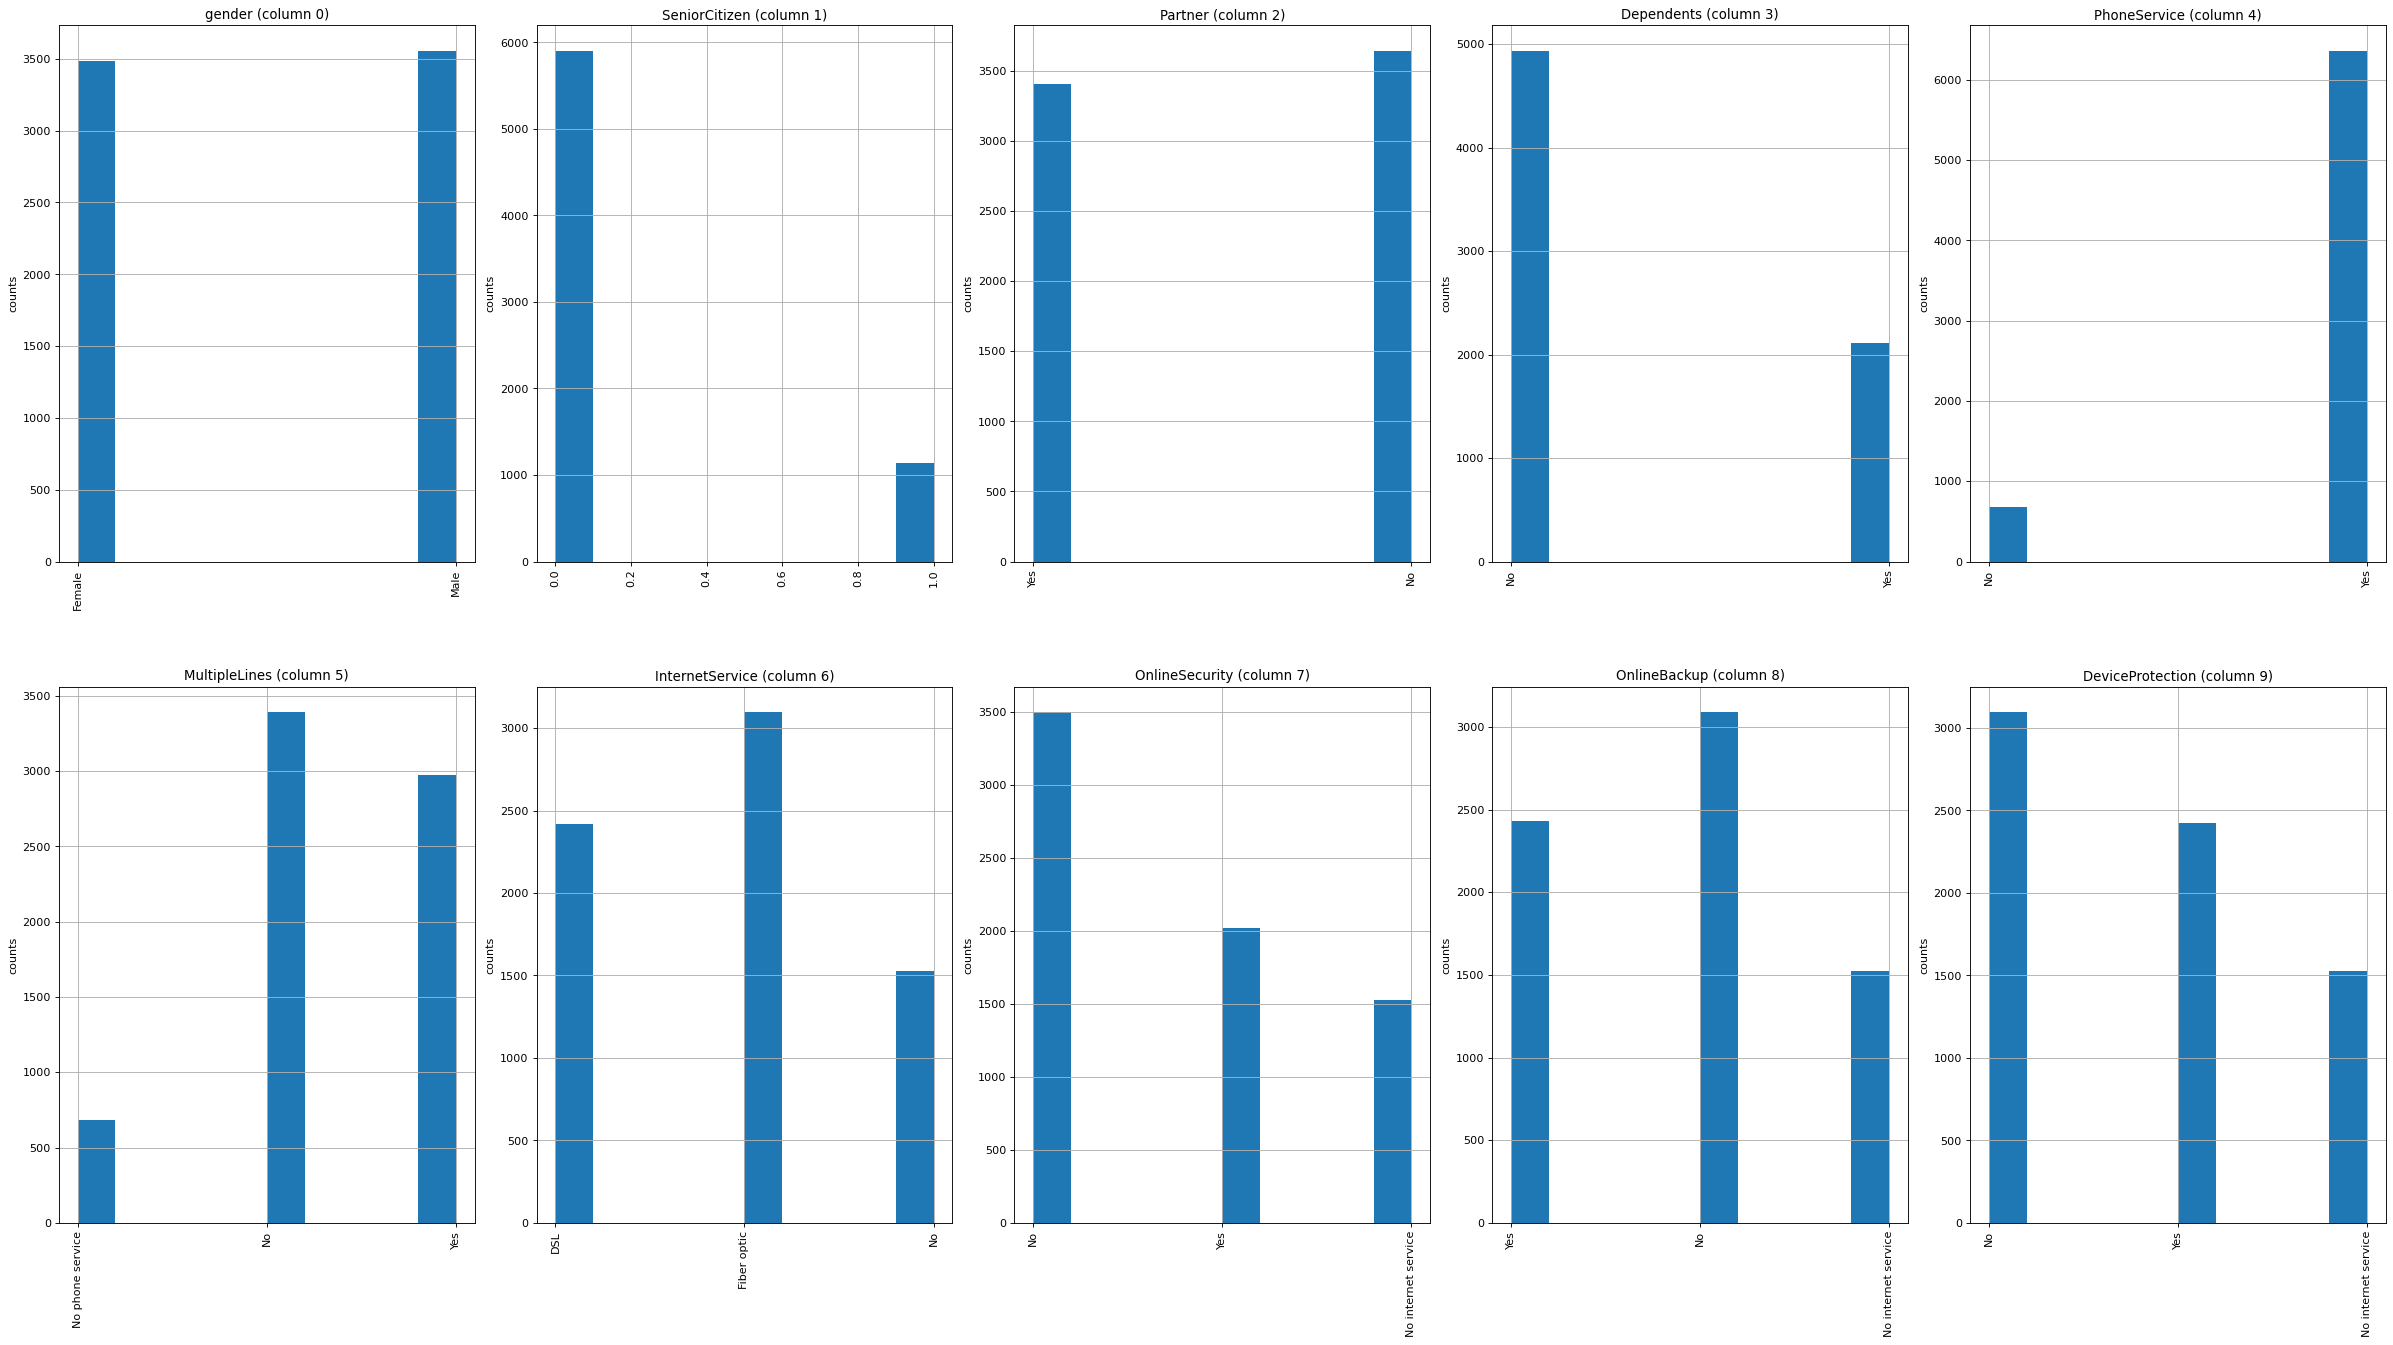

In [9]:
plot_histogram(df, 10, 5)

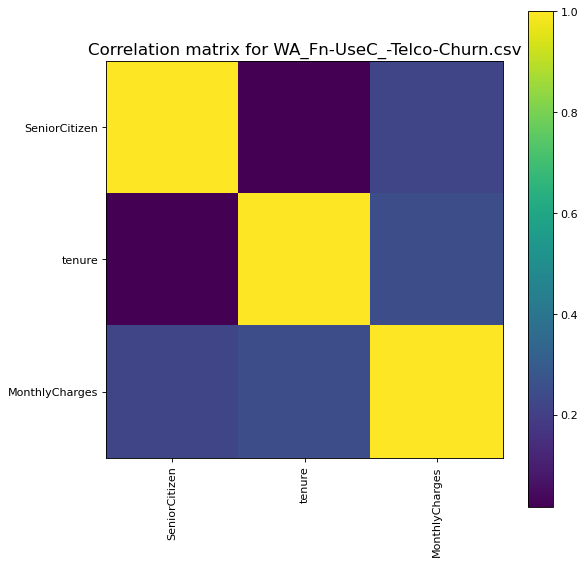

In [10]:
plot_correlation_matrix(df, 8)

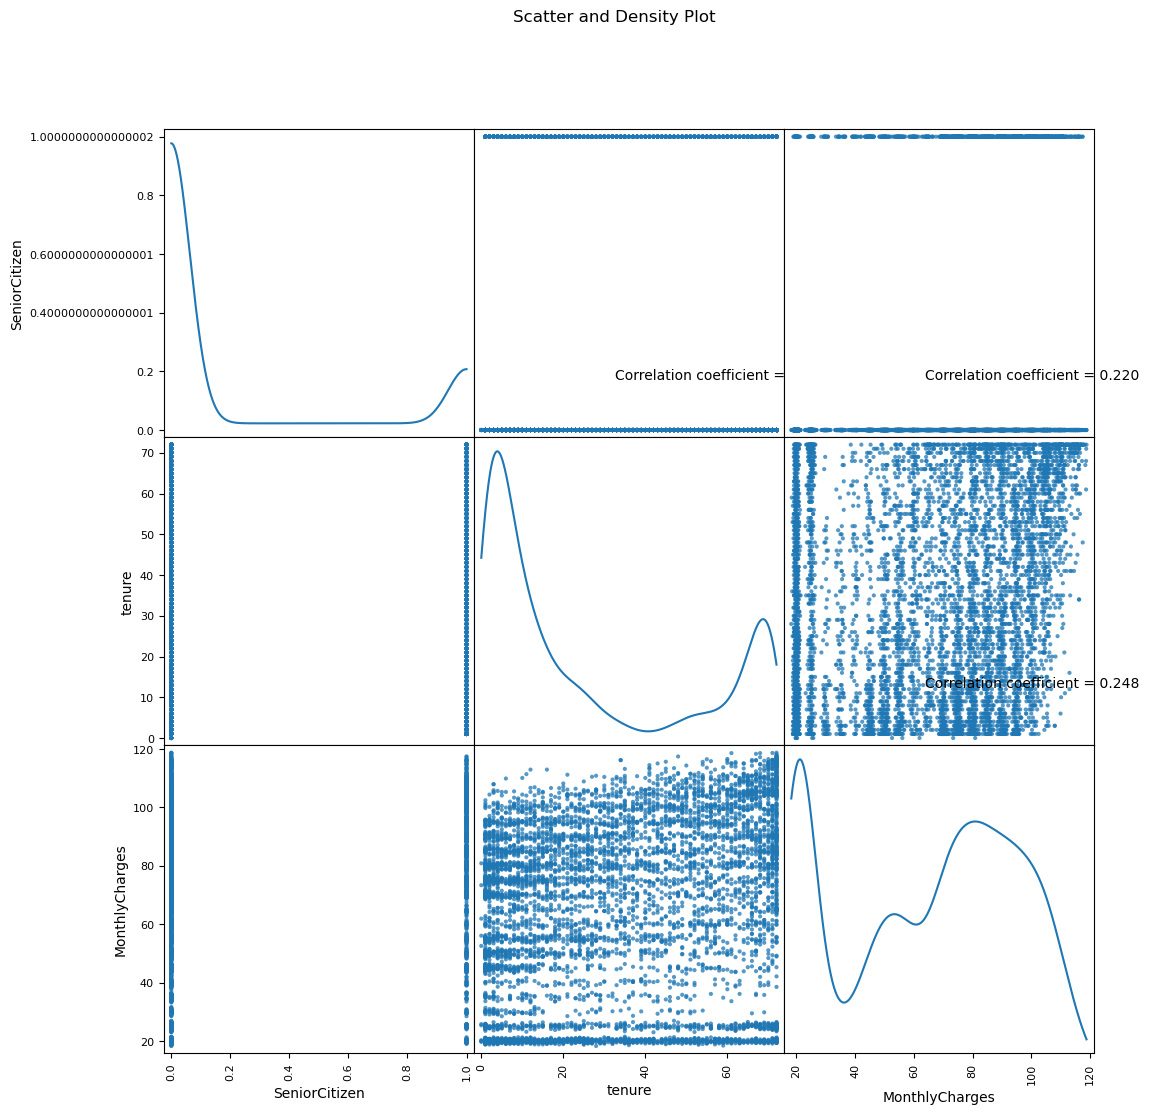

In [11]:
plot_scatter_matrix(df, 12, 10)

## Data preprocessing

Let's preprocess the dataset:
* Remove the customers' ID.
* Encode the categorical columns using dummy variables.
* Transform object columns to numeric columns and handle missing values.
* Transform the target variable "Churn" to numeric categorical variable.

In [13]:
df = df.drop("customerID", axis=1)
categorical_cols = ["gender", "Partner", "Dependents", "PhoneService", "MultipleLines", "InternetService", "OnlineSecurity", "OnlineBackup",
                    "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies", "Contract", "PaperlessBilling", "PaymentMethod"]
df_encoded = pd.get_dummies(df, columns=categorical_cols, dtype=int)
df_encoded.info()
df_encoded.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 46 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   SeniorCitizen                            7043 non-null   int64  
 1   tenure                                   7043 non-null   int64  
 2   MonthlyCharges                           7043 non-null   float64
 3   TotalCharges                             7043 non-null   object 
 4   Churn                                    7043 non-null   object 
 5   gender_Female                            7043 non-null   int64  
 6   gender_Male                              7043 non-null   int64  
 7   Partner_No                               7043 non-null   int64  
 8   Partner_Yes                              7043 non-null   int64  
 9   Dependents_No                            7043 non-null   int64  
 10  Dependents_Yes                           7043 no

SeniorCitizen  tenure  MonthlyCharges TotalCharges Churn  gender_Female  \
0              0       1           29.85        29.85    No              1   
1              0      34           56.95       1889.5    No              0   
2              0       2           53.85       108.15   Yes              0   
3              0      45           42.30      1840.75    No              0   
4              0       2           70.70       151.65   Yes              1   
5              0       8           99.65        820.5   Yes              1   
6              0      22           89.10       1949.4    No              0   
7              0      10           29.75        301.9    No              1   
8              0      28          104.80      3046.05   Yes              1   
9              0      62           56.15      3487.95    No              0   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  ...  \
0            0           0            1              1  ...   
1            1           1            0              1  ...   
2            1           1            0              1  ...   
3            1           1            0              1  ...   
4            0           1            0              1  ...   
5            0           1            0              1  ...   
6            1           1            0              0  ...   
7            0           1            0              1  ...   
8            0           0            1              1  ...   
9            1           1            0              0  ...   

   StreamingMovies_Yes  Contract_Month-to-month  Contract_One year  \
0                    0                        1                  0   
1                    0                        0                  1   
2                    0                        1                  0   
3                    0                        0                  1   
4                    0                        1                  0   
5                    1                        1                  0   
6                    0                        1                  0   
7                    0                        1                  0   
8                    1                        1                  0   
9                    0                        0                  1   

   Contract_Two year  PaperlessBilling_No  PaperlessBilling_Yes  \
0                  0                    0                     1   
1                  0                    1                     0   
2                  0                    0                     1   
3                  0                    1                     0   
4                  0                    0                     1   
5                  0                    0                     1   
6                  0                    0                     1   
7                  0                    1                     0   
8                  0                    0                     1   
9                  0                    1                     0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   
5                                        0   
6                                        0   
7                                        0   
8                                        0   
9                                        1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0              

In [14]:
# Convert TotalCharges from object to numeric and handle missing values using the mean value
df_encoded["TotalCharges"] = pd.to_numeric(df_encoded["TotalCharges"], errors="coerce")
df_encoded["TotalCharges"] = df_encoded["TotalCharges"].fillna(df_encoded["TotalCharges"].mean())

In [16]:
scaler = StandardScaler()
df_encoded[["tenure_scaled", "MonthlyCharges_scaled", "TotalCharges_scaled"]] = scaler.fit_transform(df_encoded[["tenure", "MonthlyCharges", "TotalCharges"]])

In [17]:
label_encoder = LabelEncoder()
df_encoded["Churn"] = label_encoder.fit_transform(df_encoded["Churn"])
df_encoded.head(10)

SeniorCitizen  tenure  MonthlyCharges  TotalCharges  Churn  gender_Female  \
0              0       1           29.85         29.85      0              1   
1              0      34           56.95       1889.50      0              0   
2              0       2           53.85        108.15      1              0   
3              0      45           42.30       1840.75      0              0   
4              0       2           70.70        151.65      1              1   
5              0       8           99.65        820.50      1              1   
6              0      22           89.10       1949.40      0              0   
7              0      10           29.75        301.90      0              1   
8              0      28          104.80       3046.05      1              1   
9              0      62           56.15       3487.95      0              0   

   gender_Male  Partner_No  Partner_Yes  Dependents_No  ...  \
0            0           0            1              1  ...   
1            1           1            0              1  ...   
2            1           1            0              1  ...   
3            1           1            0              1  ...   
4            0           1            0              1  ...   
5            0           1            0              1  ...   
6            1           1            0              0  ...   
7            0           1            0              1  ...   
8            0           0            1              1  ...   
9            1           1            0              0  ...   

   Contract_Two year  PaperlessBilling_No  PaperlessBilling_Yes  \
0                  0                    0                     1   
1                  0                    1                     0   
2                  0                    0                     1   
3                  0                    1                     0   
4                  0                    0                     1   
5                  0                    0                     1   
6                  0                    0                     1   
7                  0                    1                     0   
8                  0                    0                     1   
9                  0                    1                     0   

   PaymentMethod_Bank transfer (automatic)  \
0                                        0   
1                                        0   
2                                        0   
3                                        1   
4                                        0   
5                                        0   
6                                        0   
7                                        0   
8                                        0   
9                                        1   

   PaymentMethod_Credit card (automatic)  PaymentMethod_Electronic check  \
0                                      0                               1   
1                                      0                               0   
2                                      0                               0   
3                                      0                               0   
4                                      0                               1   
5                                      0                               1   
6                                      1                               0   
7                                      0                               0   
8                                      0                               1   
9                                      0                               0   

   PaymentMethod_Mailed check  tenure_scaled  MonthlyCharges_scaled  \
0                           0      -1.277445              -1.160323   
1                           1       0.066327              -0.259629   
2                           1      -1.236724              -0.362660   
3                           0       0.514251              -0.7

In [22]:
X = df_encoded.drop("Churn", axis=1)
y = df_encoded["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((5634, 48), (1409, 48), (5634,), (1409,))

## Machine Learning Models

Applying different supervised machine learning models.

### Logistic Regression

In [30]:
model = LogisticRegression(random_state=42, max_iter=1000, solver='liblinear', verbose=1)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

[LibLinear]iter  1 act 6.370e+02 pre 5.820e+02 delta 3.118e-04 f 3.905e+03 |g| 4.123e+06 CG   1
iter  2 act 3.309e+01 pre 3.038e+01 delta 3.118e-04 f 3.268e+03 |g| 7.103e+05 CG   1
cg reaches trust region boundary
iter  3 act 5.973e+00 pre 5.959e+00 delta 1.247e-03 f 3.235e+03 |g| 9.434e+04 CG   2
cg reaches trust region boundary
iter  4 act 1.671e+01 pre 1.685e+01 delta 3.071e-03 f 3.229e+03 |g| 1.681e+04 CG   1
iter  5 act 3.729e+00 pre 3.596e+00 delta 3.071e-03 f 3.212e+03 |g| 2.176e+05 CG   1
cg reaches trust region boundary
iter  6 act 4.604e+01 pre 4.602e+01 delta 1.228e-02 f 3.209e+03 |g| 1.928e+04 CG   2
cg reaches trust region boundary
iter  7 act 1.412e+02 pre 1.402e+02 delta 3.226e-02 f 3.163e+03 |g| 2.371e+04 CG   2
cg reaches trust region boundary
iter  8 act 1.929e+02 pre 1.824e+02 delta 3.614e-02 f 3.021e+03 |g| 2.706e+04 CG   3
iter  9 act 3.242e+00 pre 3.141e+00 delta 3.614e-02 f 2.829e+03 |g| 2.273e+05 CG   1
cg reaches trust region boundary
iter 10 act 1.395e+02 pre 

### XGBoost

In [32]:
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1036
           1       0.64      0.55      0.59       373

    accuracy                           0.80      1409
   macro avg       0.74      0.72      0.73      1409
weighted avg       0.79      0.80      0.79      1409

[[919 117]
 [167 206]]


### Random Forest

In [35]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_pred = rf_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.83      0.91      0.86      1036
           1       0.65      0.47      0.54       373

    accuracy                           0.79      1409
   macro avg       0.74      0.69      0.70      1409
weighted avg       0.78      0.79      0.78      1409

[[940  96]
 [198 175]]


### Gradient Boosting

In [37]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train, y_train)

y_pred = gb_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.53      0.59       373

    accuracy                           0.81      1409
   macro avg       0.76      0.72      0.73      1409
weighted avg       0.80      0.81      0.80      1409

[[941  95]
 [176 197]]


### Multi-Layer Perceptron

In [41]:
mlp_model = MLPClassifier(hidden_layer_sizes=(5, 2), random_state=42)
mlp_model.fit(X_train, y_train)

y_pred = mlp_model.predict(X_test)

print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.88      0.87      1036
           1       0.65      0.64      0.65       373

    accuracy                           0.81      1409
   macro avg       0.76      0.76      0.76      1409
weighted avg       0.81      0.81      0.81      1409

[[907 129]
 [134 239]]


## Dimensionality reduction and visualization

### Principal Component Analysis (PCA)

In [44]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train)

fig = px.scatter(x=X_pca[:,0], y=X_pca[:, 1], color=y_train)
fig.update_layout(title="PCA visualization", xaxis_title="First Principal Component", yaxis_title="Second Principal Component")
fig.show()

### t-distributed stochastic neighbor embedding (t-SNE)

In [46]:
tsne = TSNE(n_components=2, random_state=42)
X_tsne = tsne.fit_transform(X_train)
tsne.kl_divergence_

0.4419073462486267

In [47]:
fig = px.scatter(x=X_tsne[:,0], y=X_tsne[:,1], color=y_train)
fig.update_layout(title="t-SNE visualization", xaxis_title="First t-SNE", yaxis_title="Second t-SNE")
fig.show()

### Isomap

In [53]:
isomap = Isomap(n_components=2, n_neighbors=20)
X_isomap = isomap.fit_transform(X_train)
fig = px.scatter(x=X_isomap[:,0], y=X_isomap[:,1], color=y_train)
fig.update_layout(title="Isomap visualization", xaxis_title="First Isomap", yaxis_title="Second Isomap")
fig.show()

### Locally linear embedding

In [56]:
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=5)
X_lle = lle.fit_transform(X_train)
fig = px.scatter(x=X_lle[:,0], y=X_lle[:,1], color=y_train)
fig.update_layout(title="Locally linear embedding visualization", xaxis_title="First", yaxis_title="Second")
fig.show()